In [25]:
#!pip install plotguy
#!pip install hkfdb
#!pip install yfinance --upgrade
#!pip install talib-binary

In [26]:
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib

In [27]:
import os
import sys
import copy
import datetime
import time
import itertools

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import plotguy

import yfinance as yf
import talib as ta
from talib import MA_Type
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#import own data manipulation toolkit
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data')
#import _datatoolkit as dtk

**Defining Data Folder Structures**

In [30]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

**1) Define Tickers List, Backtest Date Range and Data Retrival Intervals**

In [31]:
# define list of tickers to backtest
ticker_list = ['ARCC', 'STAG', 'O', 'WPC', 'MAIN', 'ABR', 'ACRE', 'DIVO', 'JEPI', 'LTC', 'OHI', 'PFLT', 'QYLD', 'SCHD', 'STOR', 'XRMI', 'TQQQ']
#ticker_list = ['IRM', 'WPC', 'UVXY', 'SQQQ', 'MOS', 'ARCC', 'HTGC', 'ACRE', 'ABR', 'CTO', 'O']

# define date range
start_date = '2021-03-20'
end_date = '2022-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 8000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [32]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50)
    globals()[ticker]['200EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=200) 
    globals()[ticker]['ATR'] = ta.ATR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['RSI'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)
    #globals()[ticker]['BBANDS_M'] = ta.BBANDS(globals()[ticker]['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] / \
    #                                ta.BBANDS(globals()[ticker]['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1].mean()
    globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close'], matype=MA_Type.T3)
    globals()[ticker]['RSI -1'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14).shift(1)
    globals()[ticker] = globals()[ticker].drop(['Volume', 'MACD_hist'], axis=1)
    globals()[ticker] = globals()[ticker].round(4).dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker]['Position'] = 0
    globals()[ticker][['Equity Value', 'MDD_dollar', 'PNL', 'Holding Period', 'Win Count']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)


**3) Building the DataFrame List, Perform Backtesting**

In [33]:
df_list = [ARCC, STAG, O, WPC, MAIN, ABR, ACRE, DIVO, JEPI, LTC, OHI, PFLT, QYLD, SCHD, STOR, XRMI, TQQQ]
#df_list = [IRM, WPC, UVXY, SQQQ, MOS, ARCC, HTGC, ACRE, ABR, CTO, O]

**Back Testing** </b>


*   Backtesting of Trade Logic across all tickers and in the designated timeframe
*   Backtesting for Trade strategy with simulated PNL



In [34]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [35]:
global trade_list
trade_list = []
pos_size = round(initial_capital/len(ticker_list),2)

3.1) Trade Strategy - MACD + RSI

In [36]:
def backtest_macd(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = initial_equity_value * 0.85
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_50EMA       = df.loc[i, '50EMA']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_MACD > now_MACD_signal) and (now_rsi < 45)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True) and (now_MACD < now_MACD_signal) or \
      ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])) and (now_open*lot_size < stop_loss):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

3.2) Trade Strategy - Bollinger Bands + RSI 

In [38]:
def backtest_bbrsi(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = initial_equity_value * 0.85
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_50EMA       = df.loc[i, '50EMA']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_BBand_M    = df.loc[i, 'BBand_M']
    now_rsi_1       = df.loc[i, 'RSI -1']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_open > now_BBand_M) and (now_rsi_1 < 40)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True) and ((now_open < now_BBand_M) and (now_rsi_1 > 60)) or \
      ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])) and (now_open*lot_size < stop_loss):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

**4) Projecting Total PNL** </br>


*   Creating for loop to simulate PNL based on particular strategy
*   Calculate portfolio PNL, ROI etc.



In [39]:
bbrsi_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_bbrsi(df)
    bbrsi_result_list.append(test_result)

    bbrsi_result_df = pd.DataFrame(bbrsi_result_list)
    bbrsi_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    None

In [40]:
measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: Bollinger Bands + RSI')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((bbrsi_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = bbrsi_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (bbrsi_result_df['No of Trade'].sum()))
print('Total PNL: USD', bbrsi_result_df['Total PNL'].sum().round(2))
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', bbrsi_result_df['Win Rate %'].mean().round(2), '%')
bbrsi_result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)

Trading Strategy: Bollinger Bands + RSI
Trade period: 2022-01-04 to 2022-11-30
Total No of Trades Executed: 32
Total PNL: USD 355.96
Required Capital: USD 8000
ROI:  4.45 %
Avg Win Rate:  59.38 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %
6,ACRE,2,122.31,61.16,98.20,35.50,100.00
3,WPC,3,120.31,40.10,52.27,35.67,100.00
10,PFLT,2,75.43,37.72,76.28,30.50,100.00
9,OHI,1,73.98,73.98,102.38,71.00,100.00
0,ARCC,2,70.57,35.28,62.64,37.50,100.00
5,ABR,2,66.73,33.36,103.17,80.00,50.00
13,STOR,2,52.17,26.08,81.05,73.00,50.00
2,O,3,50.64,16.88,61.25,44.67,66.67
11,QYLD,3,10.25,3.42,25.45,50.33,33.33
8,JEPI,2,4.73,2.37,14.65,47.50,50.00


In [41]:
macd_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    macd_test_result = backtest_macd(df)
    macd_result_list.append(macd_test_result)

    macd_result_df = pd.DataFrame(macd_result_list)
    macd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    None

In [42]:
measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: MACD + RSI')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((macd_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = macd_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (macd_result_df['No of Trade'].sum()))
print('Total PNL: USD', macd_result_df['Total PNL'].sum().round(2))
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', macd_result_df['Win Rate %'].mean().round(2), '%')
macd_result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)

Trading Strategy: MACD + RSI
Trade period: 2022-01-04 to 2022-11-30
Total No of Trades Executed: 64
Total PNL: USD 696.01
Required Capital: USD 8000
ROI:  8.7 %
Avg Win Rate:  51.08 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %
3,WPC,4,119.69,29.92,68.22,26.00,75.00
0,ARCC,3,86.95,28.98,68.81,28.00,66.67
9,LTC,2,81.79,40.90,56.29,26.00,100.00
5,ABR,4,77.55,19.39,117.25,32.83,25.00
6,ACRE,4,65.29,16.32,73.10,22.83,50.00
10,OHI,1,59.52,59.52,102.38,48.00,100.00
2,O,1,58.62,58.62,65.41,41.75,100.00
4,MAIN,3,45.93,15.31,84.84,16.50,33.33
1,STAG,5,44.93,8.99,112.58,37.00,40.00
11,PFLT,2,36.85,18.42,82.43,24.50,50.00


**5) Detailed Portfolio Transaction List**

In [43]:
# full trading transactions across everything
full_trade = pd.DataFrame(trade_list)
full_trade.columns = ['Transaction Date', 'Ticker', 'Buy/Sell Price', 'Trade Opened', 'Lot Size', 'Ttl Equity Value', 'PNL', 'Holding Days']

In [44]:
full_trade.head()

,Transaction Date,Ticker,Buy/Sell Price,Trade Opened,Lot Size,Ttl Equity Value,PNL,Holding Days
0,2022-05-16,ARCC,18.3503,True,25.0,458.510,NaN,NaN
1,2022-07-29,ARCC,18.8282,False,25.0,470.705,11.18,51.0
2,2022-09-29,ARCC,17.2900,True,27.0,466.560,NaN,NaN
3,2022-11-02,ARCC,19.5200,False,27.0,527.040,59.39,24.0
4,2022-01-26,STAG,39.9971,True,11.0,439.860,NaN,NaN


In [45]:
trade_plot = full_trade[['Transaction Date', 'Ttl Equity Value', 'PNL']]

Text(0.5, 1.0, 'Total Equity Value for the Trading Period')

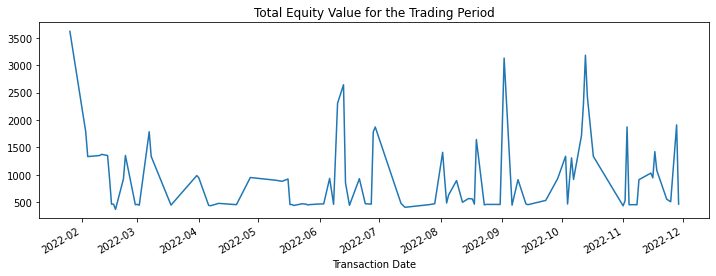

In [46]:
# graph plot - full year total equity value
trade_plot.groupby('Transaction Date')['Ttl Equity Value'].sum().plot(figsize=(12,4))
plt.title('Total Equity Value for the Trading Period')

In [47]:
full_trade[full_trade['Ticker'] == 'UVXY']

,Transaction Date,Ticker,Buy/Sell Price,Trade Opened,Lot Size,Ttl Equity Value,PNL,Holding Days


In [48]:
# Class to call Pandas by row and column
# https://stackoverflow.com/questions/28754603/indexing-pandas-data-frames-integer-rows-named-columns 
class XLocIndexer:
    def __init__(self, frame):
        self.frame = frame
    
    def __getitem__(self, key):
        row, col = key
        return self.frame.iloc[row][col]

pd.core.indexing.IndexingMixin.xloc = property(lambda frame: XLocIndexer(frame))